# Import libraries

In [ ]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Machine Learning / Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Data Splitting
from sklearn.model_selection import train_test_split

# Load the dataset

In [2]:
import os
import pandas as pd

train_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

# --- Build dataframe for Train ---
train_data = []
for label, directory in enumerate(os.listdir(train_dir)):
    dir_path = os.path.join(train_dir, directory)
    if os.path.isdir(dir_path):  # ensure it's a folder
        for filename in os.listdir(dir_path):
            image_path = os.path.join(dir_path, filename)
            train_data.append({'image_path': image_path, 'label': label})

train_df = pd.DataFrame(train_data)

test_data = []
for label, directory in enumerate(os.listdir(test_dir)):
    dir_path = os.path.join(test_dir, directory)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            image_path = os.path.join(dir_path, filename)
            test_data.append({'image_path': image_path, 'label': label})

test_df = pd.DataFrame(test_data)

# --- Combine ---
df = pd.concat([train_df, test_df], ignore_index=True)
del train_df, test_df

# Show summary
print("Total images:", len(df))
print(df.head())

Total images: 2357
                                          image_path  label
0  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0
1  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0
2  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0
3  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0
4  /kaggle/input/skin-cancer9-classesisic/Skin ca...      0


 This set consists of 2357 images of malignant and benign oncological diseases, which were formed from The International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

    actinic keratosis
    basal cell carcinoma
    dermatofibroma
    melanoma
    nevus
    pigmented benign keratosis
    -seborrheic keratosis
    squamous cell carcinoma
    vascular lesion


In [3]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'pigmented benign keratosis',
 1: 'melanoma',
 2: 'vascular lesion',
 3: 'actinic keratosis',
 4: 'squamous cell carcinoma',
 5: 'basal cell carcinoma',
 6: 'seborrheic keratosis',
 7: 'dermatofibroma',
 8: 'nevus'}

In [4]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     478       
1               melanoma                       454       
2               vascular lesion                142       
3               actinic keratosis              130       
4               squamous cell carcinoma        197       
5               basal cell carcinoma           392       
6               seborrheic keratosis           80        
7               dermatofibroma                 111       
8               nevus                          373       
------------------------------------------------------------
Total                                         2357      


In [ ]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

Above line of code ensures that we take only first 2500 images from each class - so that there is no class imbalance in the dataset

# GPU Configurations

In [6]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

4

In [8]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

# Exploratory Data Analysis

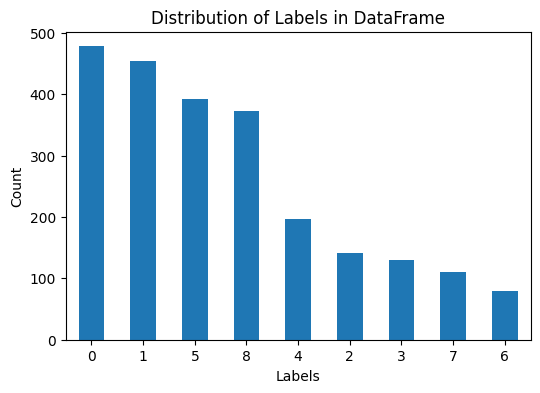

In [9]:
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()

plt.figure(figsize=(6,4))
label_counts.plot(kind='bar')

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in DataFrame')
plt.xticks(rotation=0)
plt.show()

The dataset is imbalanced with class 0:pigmented benign keratosis having more images and 6: seborrheic keratosis having the least number of images.

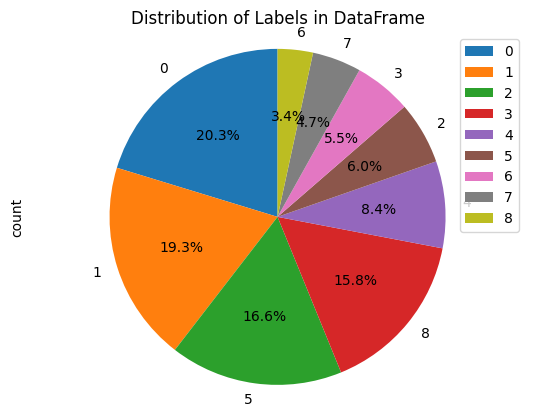

In [10]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [11]:
df.head()

,image_path,label,image
0,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0,"[[[152, 131, 151], [153, 131, 151], [150, 128,..."
1,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0,"[[[170, 137, 151], [172, 140, 156], [170, 138,..."
2,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0,"[[[247, 170, 159], [247, 169, 159], [244, 166,..."
3,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0,"[[[174, 143, 162], [173, 142, 162], [171, 138,..."
4,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0,"[[[144, 124, 134], [147, 127, 138], [151, 131,..."


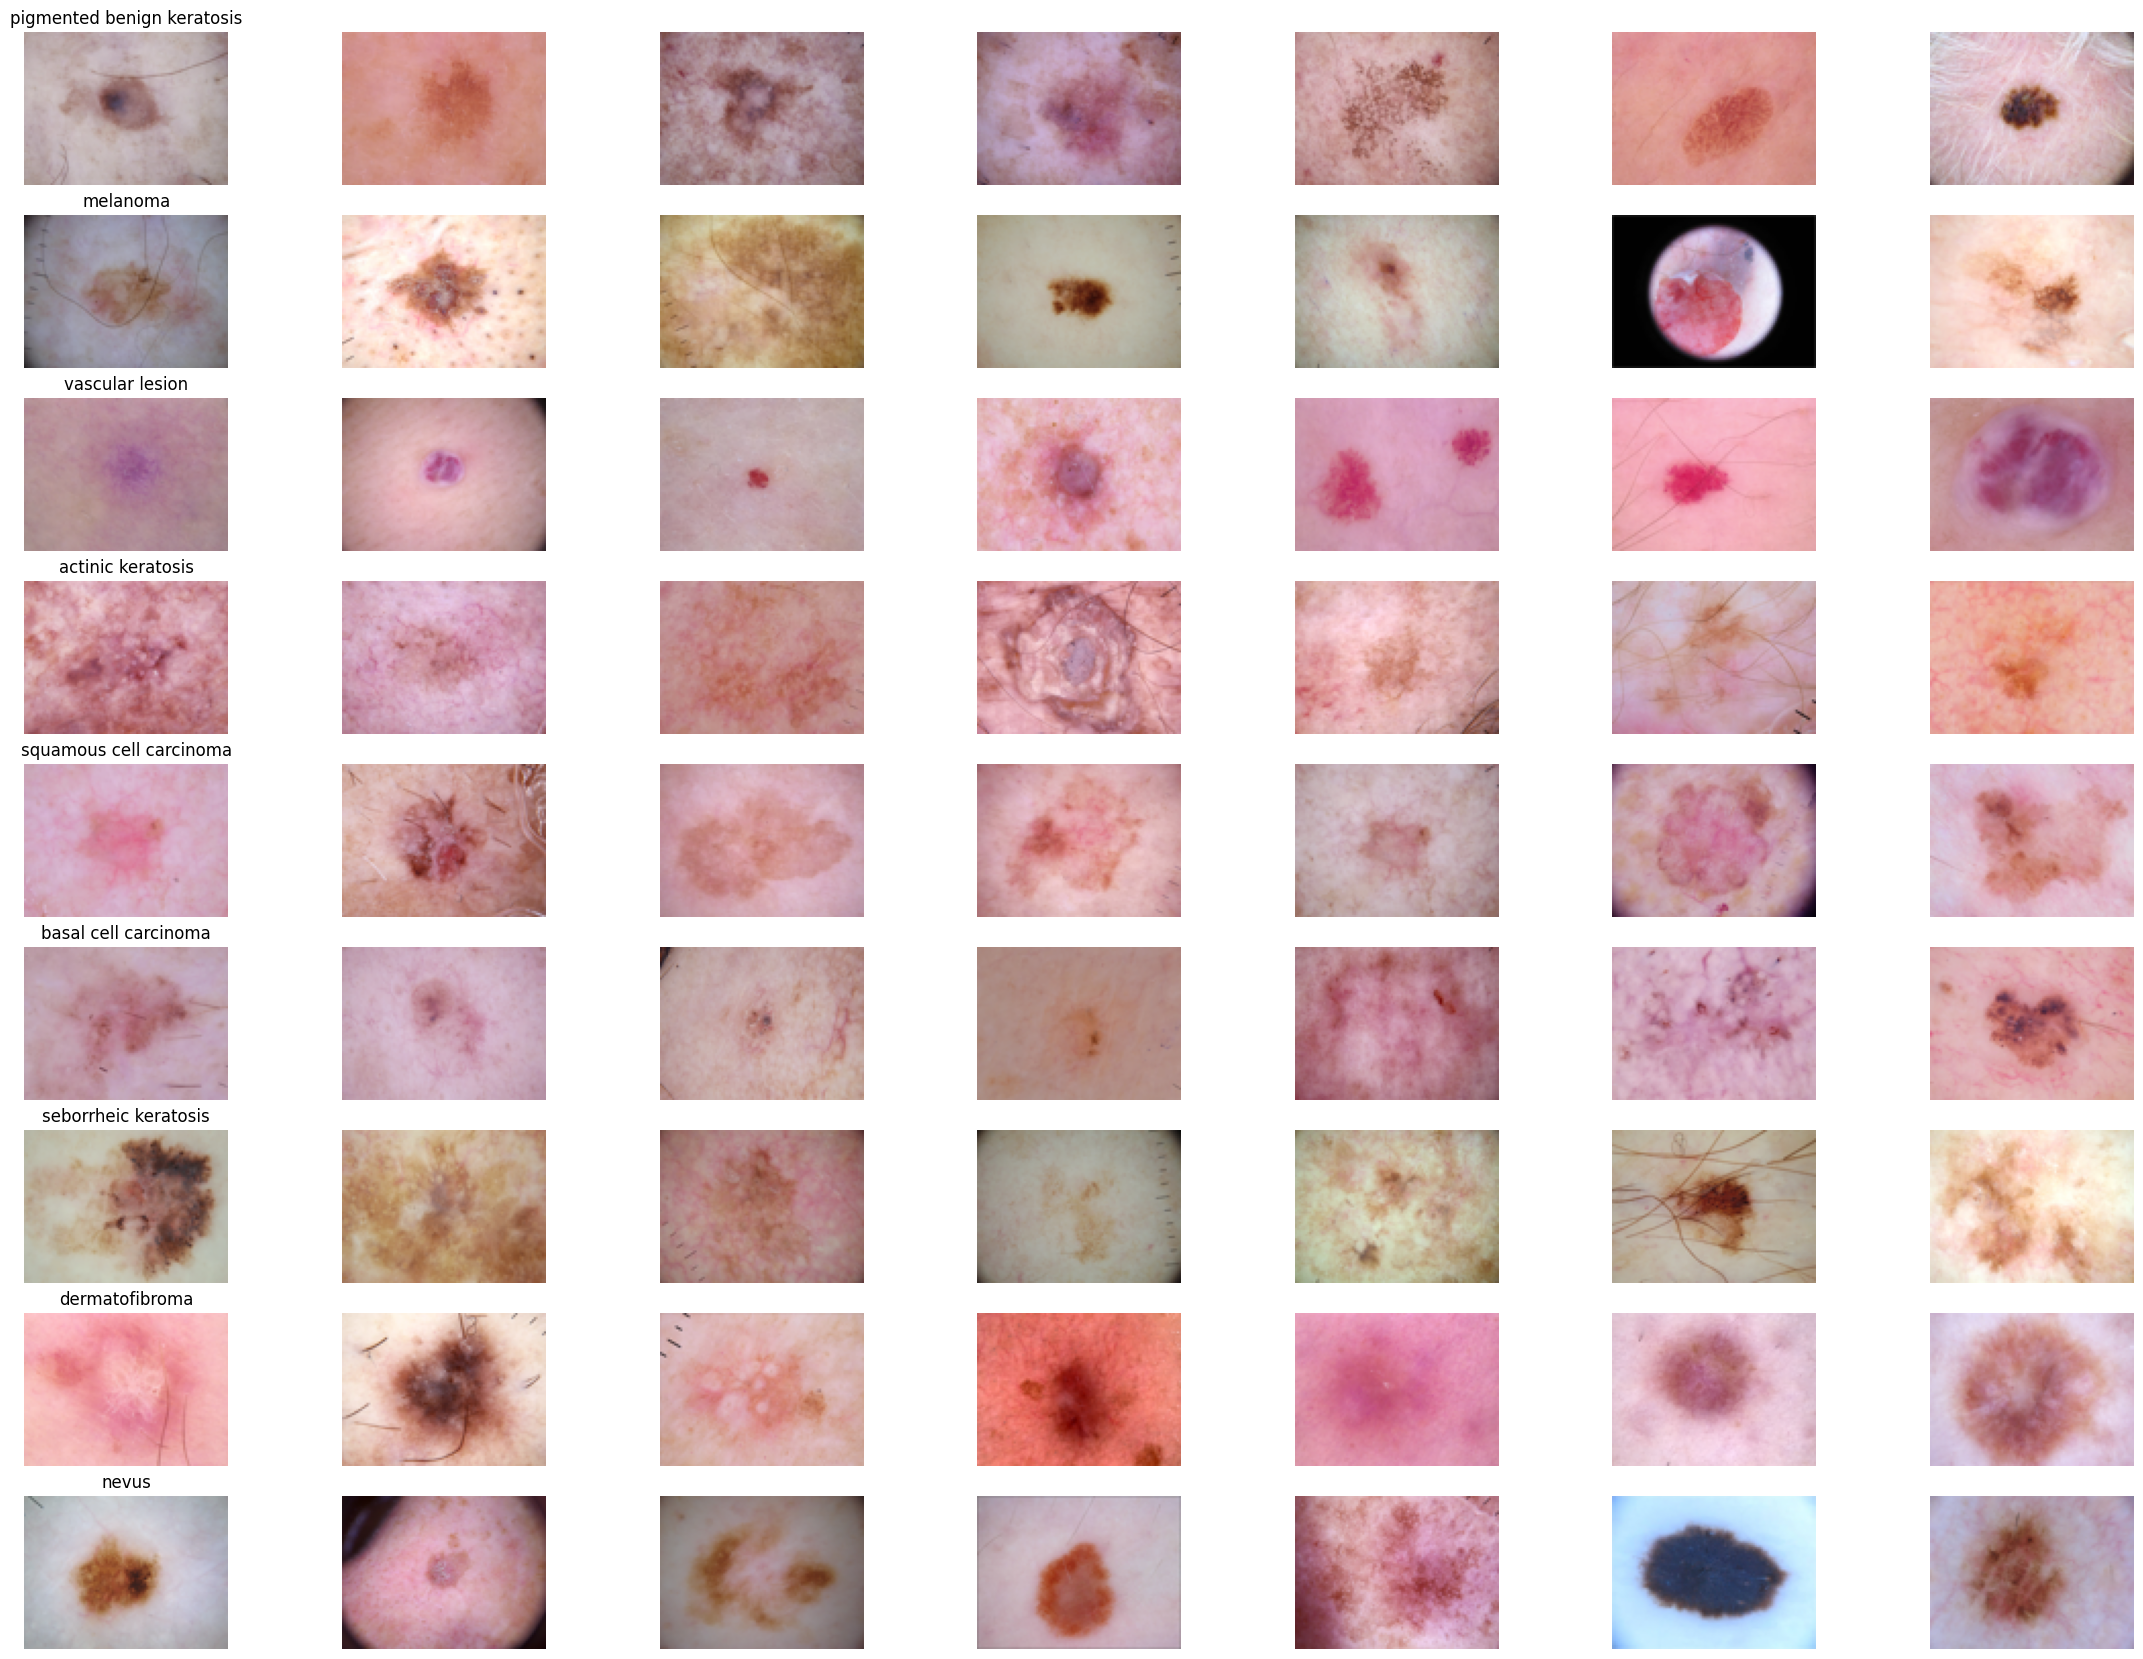

In [12]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

The images of various skin cancer

In [13]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    2357
Name: count, dtype: int64

The above code is used to check how many images of different sizes are there in the dataset. For the given dataset - all the images are of same size (height,width,color_channels)

# Data Augmentatation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

This code creates an ImageDataGenerator that performs data augmentation on your training images to help reduce overfitting. It randomly applies a set of transformations each time an image is loaded: rotating up to 20°, shifting the image horizontally or vertically by up to 20%, applying shear distortions, zooming in/out by 20%, and flipping the image horizontally. When new pixel values are needed (after rotation or shifting), it fills them using the nearest pixel values (fill_mode='nearest'). These transformations artificially expand and diversify your dataset, helping the model learn more robust features and generalize better.

In [15]:
# Create an empty list to store augmented data
augmented_data = []

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate how many more images are needed
    num_images_needed = max_images_per_class - len(image_arrays)
    
    if num_images_needed > 0:
        # Randomly choose images to augment
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        for image_array in selected_images:
            # Reshape to (1, height, width, channels)
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Create iterator for augmentation
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Generate one augmented image
            for _ in range(augmented_images.n):
                augmented_image_array = next(augmented_images)[0].astype('uint8')
                augmented_data.append({
                    'image_path': None,
                    'label': class_label,
                    'image': augmented_image_array
                })
    
    # Add original images too
    for _, row in df.loc[df['label'] == class_label].iterrows():
        augmented_data.append({
            'image_path': row['image_path'],
            'label': row['label'],
            'image': row['image']
        })

# Create dataframe from all augmented data
augmented_df = pd.DataFrame(augmented_data)

df = (
    augmented_df.groupby('label')
                .head(max_images_per_class)
                .reset_index(drop=True)
)

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

del augmented_df


This code balances your dataset by equalizing the number of images in each class using data augmentation. For each class, it checks how many images are missing to reach max_images_per_class and randomly selects existing images to generate new augmented versions using the previously defined ImageDataGenerator. Each selected image is expanded, passed through the augmentation pipeline, and the resulting transformed image is added to a list along with its label. Original images are also added. After all classes are processed, a new dataframe is created containing both original and augmented images, but only up to the maximum required per class. Finally, the combined dataset is shuffled to avoid ordering bias, creating a balanced dataset where each class has the same number of images.

In [16]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     2500      
1               melanoma                       2500      
2               vascular lesion                2500      
3               actinic keratosis              2500      
4               squamous cell carcinoma        2500      
5               basal cell carcinoma           2500      
6               seborrheic keratosis           2500      
7               dermatofibroma                 2500      
8               nevus                          2500      
------------------------------------------------------------
Total                                         22500     


# Training the model

In [17]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [18]:
features.head()

,image
0,"[[[186, 92, 107], [186, 91, 104], [186, 89, 10..."
1,"[[[192, 134, 163], [196, 141, 170], [199, 152,..."
2,"[[[156, 120, 125], [162, 124, 128], [164, 128,..."
3,"[[[176, 113, 135], [177, 119, 139], [179, 125,..."
4,"[[[206, 162, 163], [208, 167, 171], [207, 163,..."


In [19]:
target.head()

0    0
1    3
2    7
3    3
4    4
Name: label, dtype: int64

In [20]:
print(target.shape,features.shape)

(22500,) (22500, 1)


In [21]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [22]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [23]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [24]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [25]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [26]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [27]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               pigmented benign keratosis     1602       389          509        2500      
1               melanoma                       1596       407          497        2500      
2               vascular lesion                1594       417          489        2500      
3               actinic keratosis              1531       432          537        2500      
4               squamous cell carcinoma        1615       393          492        2500      
5               basal cell carcinoma           1586       420          494        2500      
6               seborrheic keratosis           1620       375          505        2500      
7               dermatofibroma                 1617       

In [28]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
8    2500
dtype: int64

In [29]:
input_shape = df['image'][0].shape

In [30]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

# DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

I0000 00:00:1763959371.248132      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 2, 3, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11520)          │        46,080 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,898,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,271,433 (92.59 MB)

 Trainable params: 24,019,337 (91.63 MB)

 Non-trainable params: 252,096 (984.75 KB)

This code builds a classification model by stacking custom layers on top of a pretrained **DenseNet201** backbone. DenseNet201 is added without its original top layers (`include_top=False`) so it acts as a powerful feature extractor for your images, using ImageNet weights for strong initial representations. The extracted features are then flattened and passed through **BatchNormalization** to stabilize training, followed by **Dropout** layers (0.5 and 0.3) to reduce overfitting. A fully connected layer with **512 neurons** and ReLU activation learns high-level patterns, and finally a softmax output layer predicts the class probabilities for the given number of categories. The full architecture is then summarized using `model.summary()`, showing all layers and parameters.


In [32]:
# compile model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=5,
                             verbose=1,
                             restore_best_weights=True)

Here is the explanation in a **clear, short, beginner-friendly paragraph**:

To train the model effectively, we compile it using the **Adam optimizer** with a learning rate of **0.001**, which helps the network adjust its weights smoothly during training. The loss function used is **categorical cross-entropy**, suitable for multi-class classification, and we track accuracy as the main metric. To improve training stability, we include a **ReduceLROnPlateau** callback, which automatically reduces the learning rate by half whenever the validation loss stops improving, allowing the model to fine-tune more precisely. Additionally, **EarlyStopping** is applied to stop training if the validation loss does not improve for several epochs, preventing overfitting and restoring the best-performing model weights.


In [33]:
# Fit the model
epochs = 50
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/50


I0000 00:00:1763959535.683009     122 service.cc:148] XLA service 0x794618003560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763959535.684077     122 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763959549.552899     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763959767.151920     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 ━━━━━━━━━━━━━━━━━━━━ 414s 191ms/step - accuracy: 0.3354 - loss: 3.2554 - val_accuracy: 0.4189 - val_loss: 25.1188 - learning_rate: 0.0010
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - accuracy: 0.4986 - loss: 1.3699 - val_accuracy: 0.5600 - val_loss: 29.9814 - learning_rate: 0.0010
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.5493 - loss: 1.2050 - val_accuracy: 0.5100 - val_loss: 21.0500 - learning_rate: 0.0010
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.5641 - loss: 1.1420 - val_accuracy: 0.5514 - val_loss: 1.1630 - learning_rate: 0.0010
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - accuracy: 0.6091 - loss: 1.0513 - val_accuracy: 0.6306 - val_loss: 29.7268 - learning_rate: 0.0010
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.6522 - loss: 0.9329 - val_accuracy: 0.3758 - val_loss: 2.1403 - learning_rate: 0.0010
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4975 - lo

The model was trained for a maximum of 50 epochs with a batch size of 32 using the training data, while its performance was continuously validated on the validation set. During training, two callbacks were used: ReduceLROnPlateau, which automatically lowers the learning rate when the validation loss stops improving, and EarlyStopping, which halts training if no improvement is seen for several epochs and restores the best weights. Together, these mechanisms help prevent overfitting and ensure more stable and efficient learning throughout the training process.

In [34]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
#print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

print("[INFO] accuracy: {:.2f}%".format(accuracy * 100)) 
print("[INFO] Loss: {}".format(loss)) 

450/450 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.7306 - loss: 0.6879
[INFO] accuracy: 73.23%
[INFO] Loss: 0.696027398109436


In [35]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

print("[INFO] Testing accuracy: {:.2f}%".format(accuracy * 100)) 
print("[INFO] Testing Loss: {}".format(loss)) 

141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 167ms/step - accuracy: 0.7167 - loss: 0.7586
Testing: accuracy = 0.713556  ;  loss = 0.765709
[INFO] Testing accuracy: 71.36%
[INFO] Testing Loss: 0.7657091617584229


141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step


<Axes: >

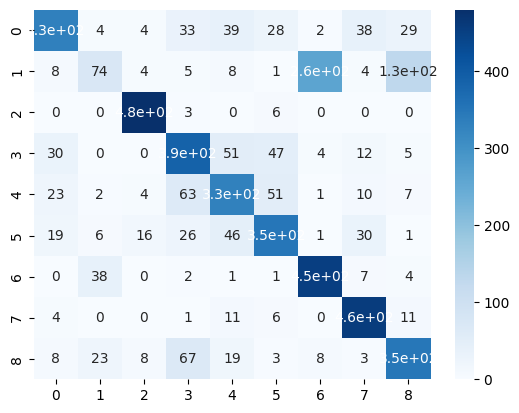

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [37]:
print(cm)

[[332   4   4  33  39  28   2  38  29]
 [  8  74   4   5   8   1 262   4 131]
 [  0   0 480   3   0   6   0   0   0]
 [ 30   0   0 388  51  47   4  12   5]
 [ 23   2   4  63 331  51   1  10   7]
 [ 19   6  16  26  46 349   1  30   1]
 [  0  38   0   2   1   1 452   7   4]
 [  4   0   0   1  11   6   0 457  11]
 [  8  23   8  67  19   3   8   3 348]]


The confusion matrix reveals that the model performs well for several classes but still struggles with a few challenging categories. Classes like vascular lesion, dermatofibroma, and seborrheic keratosis show strong diagonal dominance, meaning the model correctly classifies most samples in those categories. However, melanoma, pigmented benign keratosis, and nevus display notable misclassifications, particularly with melanoma being confused with seborrheic keratosis and nevus—indicating overlap in visual features. Similarly, actinic keratosis and squamous cell carcinoma exhibit cross-confusion, which is expected due to their close clinical resemblance. Overall, while the model captures distinctive patterns for many lesion types, certain classes with subtle or overlapping features lead to higher misclassification, suggesting that additional fine-tuning or class-specific augmentation may further improve accuracy.

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100)) 
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.7136
[INFO] accuracy: 71.36%
Precision: 0.7026
Recall: 0.7141
F1-score: 0.6933
Kappa score: 0.6777


141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step


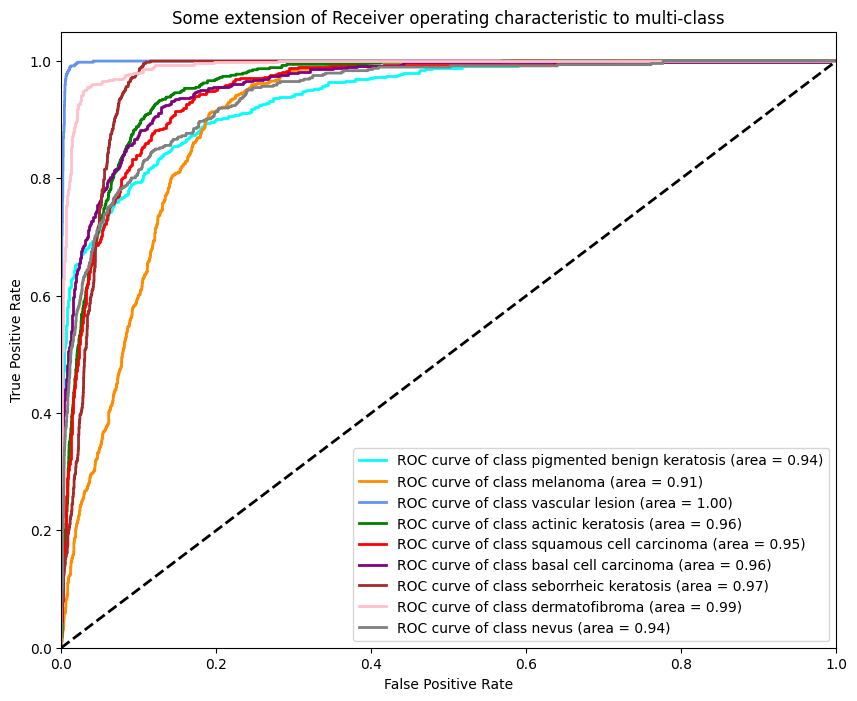

In [39]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Plotting ROC curve for each class
plt.figure(figsize=(10, 8))
n_classes = num_classes
y_score = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_map[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [40]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=[label_map[i] for i in range(num_classes)])
print(report)

                            precision    recall  f1-score   support

pigmented benign keratosis       0.78      0.65      0.71       509
                  melanoma       0.50      0.15      0.23       497
           vascular lesion       0.93      0.98      0.96       489
         actinic keratosis       0.66      0.72      0.69       537
   squamous cell carcinoma       0.65      0.67      0.66       492
      basal cell carcinoma       0.71      0.71      0.71       494
      seborrheic keratosis       0.62      0.90      0.73       505
            dermatofibroma       0.81      0.93      0.87       490
                     nevus       0.65      0.71      0.68       487

                  accuracy                           0.71      4500
                 macro avg       0.70      0.71      0.69      4500
              weighted avg       0.70      0.71      0.69      4500



This classification report indicates that the model achieves an overall **accuracy of 71%**, which is moderate but shows room for improvement. Some classes, such as **vascular lesion**, **seborrheic keratosis**, and **dermatofibroma**, perform well with high precision, recall, and F1-scores, indicating that the model identifies these lesions reliably. In contrast, **melanoma** shows very low recall (0.15) and F1-score (0.23), meaning the model fails to detect the majority of melanoma cases—a critical issue in medical diagnosis. Other classes like **pigmented benign keratosis**, **actinic keratosis**, and **nevus** have moderate performance, with recall slightly higher than precision, suggesting some over-prediction of these classes. Overall, while the model captures common lesion patterns effectively, it struggles with rare or visually similar classes, highlighting the need for more targeted data augmentation, class balancing, or fine-tuning to improve detection of high-risk categories like melanoma.


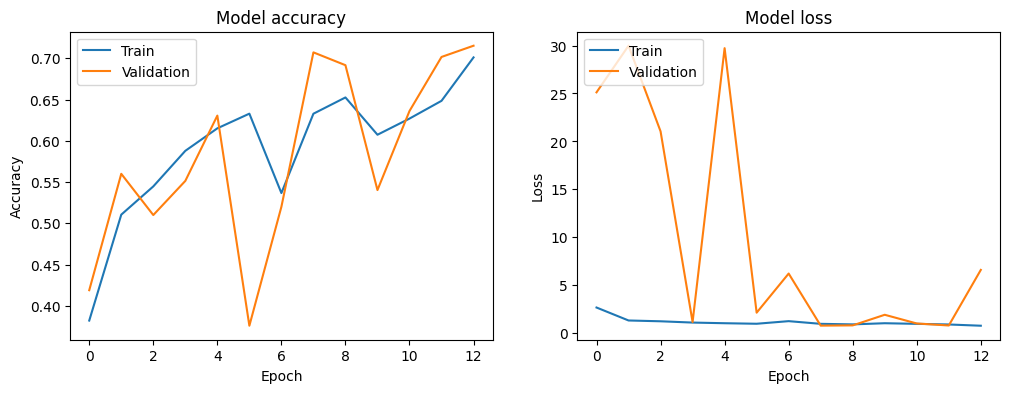

In [41]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

There is an increase in validation loss - but only minor decrease in loss, can be overfitting